In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

In [110]:
plt.rcParams['figure.dpi'] = 300

In [3]:
raw_df = pd.read_csv("train.csv",dtype={"Region_Code": "int64","Policy_Sales_Channel": "int64"})

In [4]:
full_df = raw_df.copy().astype({"Gender":"category","Region_Code":"category","Vehicle_Age":"category","Vehicle_Damage":"category","Policy_Sales_Channel":"category"})
full_df["Region_Code"] = raw_df["Region_Code"].apply(lambda code: "R" + str(code)).astype("category")
full_df["Policy_Sales_Channel"] = raw_df["Policy_Sales_Channel"].apply(lambda code: "C" + str(code)).astype("category")
full_df["Vehicle_Age"] = raw_df["Vehicle_Age"].replace({'1-2 Year': 'between 1 and 2 years', '< 1 Year': 'less than 1 year', '> 2 Years': 'more than 2 years'})

In [5]:
full_X = full_df.drop(columns = ["id","Response"])
full_y = full_df["Response"]

In [6]:
full_X["Vehicle_Age"].value_counts(dropna=False)

between 1 and 2 years    200316
less than 1 year         164786
more than 2 years         16007
Name: Vehicle_Age, dtype: int64

In [7]:
full_X["Region_Code"].value_counts(dropna=False)

R28    106415
R8      33877
R46     19749
R41     18263
R15     13308
R30     12191
R29     11065
R50     10243
R3       9251
R11      9232
R36      8797
R33      7654
R47      7436
R35      6942
R6       6280
R45      5605
R37      5501
R18      5153
R48      4681
R14      4678
R39      4644
R10      4374
R21      4266
R2       4038
R13      4036
R7       3279
R12      3198
R9       3101
R27      2823
R32      2787
R43      2639
R17      2617
R26      2587
R25      2503
R24      2415
R38      2026
R0       2021
R16      2007
R23      1960
R31      1960
R20      1935
R49      1832
R4       1801
R34      1664
R19      1535
R22      1309
R40      1295
R5       1279
R1       1008
R44       808
R42       591
R52       267
R51       183
Name: Region_Code, dtype: int64

In [8]:
full_X["Policy_Sales_Channel"].value_counts(dropna=False)

C152    134784
C26      79700
C124     73995
C160     21779
C156     10661
         ...  
C144         1
C143         1
C84          1
C123         1
C41          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

In [9]:
# full_X_DE = pd.get_dummies(data = full_X, 
#                            columns = ["Gender","Region_Code","Vehicle_Age","Vehicle_Damage","Policy_Sales_Channel"], 
#                            drop_first = False)

In [10]:
# print(full_X_DE.columns)
# full_X_DE.head(5)

In [11]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

In [12]:
# full_X_DE_scaled = pd.DataFrame(StandardScaler().fit_transform(full_X_DE),columns=full_X_DE.columns)

In [13]:
# full_X_DE_scaled["Vehicle_Damage_Yes"]

In [14]:
# print(full_X_DE_scaled.columns)
# full_X_DE_scaled.head(5)

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
full_X.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

In [18]:
categorical_columns = ["Gender","Region_Code","Vehicle_Age","Vehicle_Damage","Policy_Sales_Channel"]
binary_columns = ["Driving_License","Previously_Insured"]
numerical_columns = ["Age", "Annual_Premium", "Vintage"]

# categorical_encoder = OneHotEncoder(handle_unknown='ignore')
# numerical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
# ])

preprocessing_lr = ColumnTransformer([('cat', OneHotEncoder(drop='first'), categorical_columns), ('bin', 'passthrough', binary_columns), ('num', StandardScaler(), numerical_columns)])
preprocessing_rf = ColumnTransformer([('cat', OneHotEncoder(), categorical_columns), ('bin', 'passthrough', binary_columns), ('num', 'passthrough', numerical_columns)])
preprocessing_xgb = ColumnTransformer([('cat', OneHotEncoder(), categorical_columns), ('bin', 'passthrough', binary_columns), ('num', 'passthrough', numerical_columns)])

In [19]:
lr_model = Pipeline([
    ('preprocess', preprocessing_lr),
    ('classifier', LogisticRegression(random_state=0, max_iter = 50000))
])

In [20]:
lr_model.fit(full_X,full_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Region_Code',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', 'passthrough',
                                                  ['Driving_License',
                                                   'Previously_Insured']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier',
                 LogisticRegression(max_iter=50000, random_state=0))])

In [21]:
lr_ohe = lr_model.named_steps['preprocess'].named_transformers_['cat']

lr_feature_names_ohe = lr_ohe.get_feature_names(input_features=categorical_columns)
lr_feature_names = np.r_[lr_feature_names_ohe, binary_columns, numerical_columns]

In [266]:
plt.rcParams['figure.figsize'] = [3.8,3]

<AxesSubplot:>

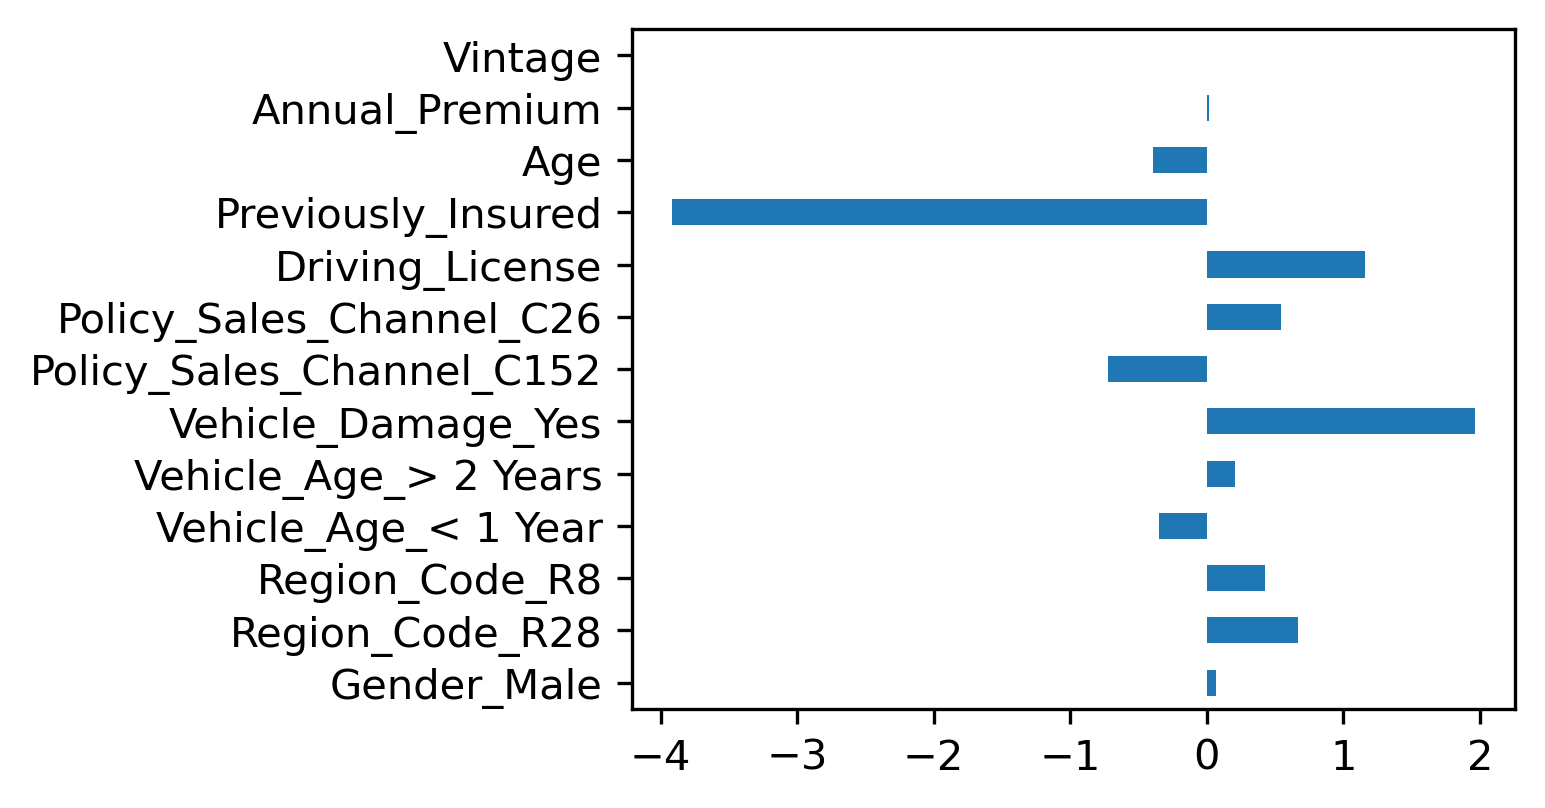

In [267]:
lr_importance_full = pd.Series(lr_model.named_steps['classifier'].coef_[0], index = pd.Index(lr_feature_names).str.replace('less than 1 year','< 1 Year').str.replace('more than 2 years','> 2 Years'))
lr_importance_filter = (~(lr_importance_full.index.str.startswith("Policy_Sales_Channel") | lr_importance_full.index.str.startswith("Region_Code"))) | lr_importance_full.index.isin(["Region_Code_R28","Region_Code_R8","Policy_Sales_Channel_C152","Policy_Sales_Channel_C26"])
lr_importance_full[lr_importance_filter].plot.barh()#title = 'Coefficient after standardizing numerical variables')

In [226]:
ax.transAxes

In [23]:
lr_pi_results = permutation_importance(lr_model,full_X,full_y)

In [276]:
plt.rcParams['figure.figsize'] = [4.225,3]

<AxesSubplot:>

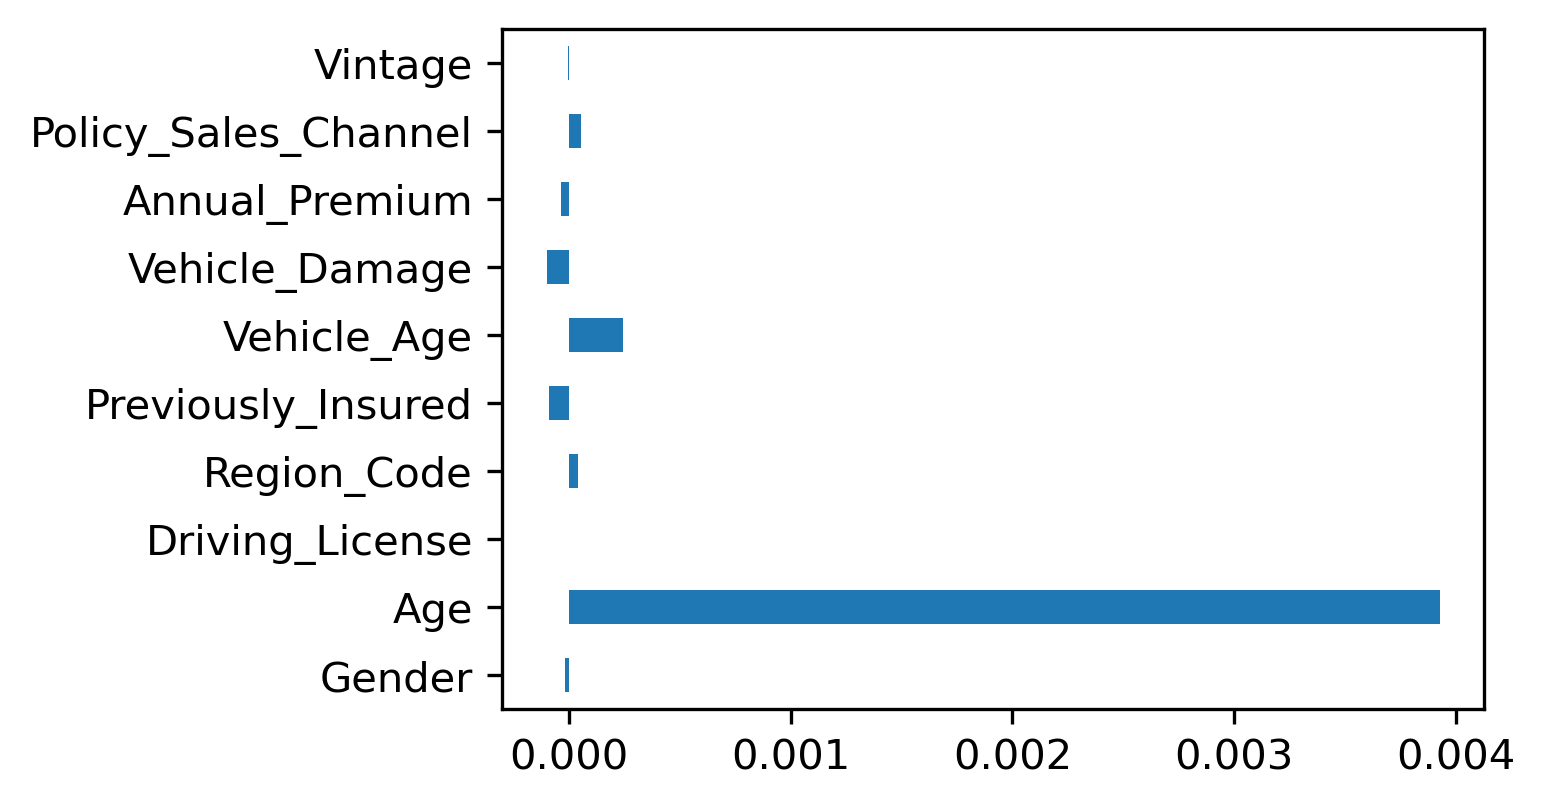

In [277]:
lr_perm_importance_full = pd.Series(lr_pi_results.importances_mean, index = full_X.columns)
lr_perm_importance_full.plot.barh()#title='Permutation Importance (5 repeats)')

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf_model = Pipeline([
    ('preprocess', preprocessing_rf),
    ('classifier', RandomForestClassifier(random_state = 0))
])

In [27]:
rf_model.fit(full_X,full_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Gender', 'Region_Code',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', 'passthrough',
                                                  ['Driving_License',
                                                   'Previously_Insured']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [28]:
rf_ohe = rf_model.named_steps['preprocess'].named_transformers_['cat']

rf_feature_names_ohe = rf_ohe.get_feature_names(input_features=categorical_columns)
rf_feature_names = np.r_[rf_feature_names_ohe, binary_columns, numerical_columns]

In [283]:
plt.rcParams['figure.figsize'] = [4.21,3]

<AxesSubplot:>

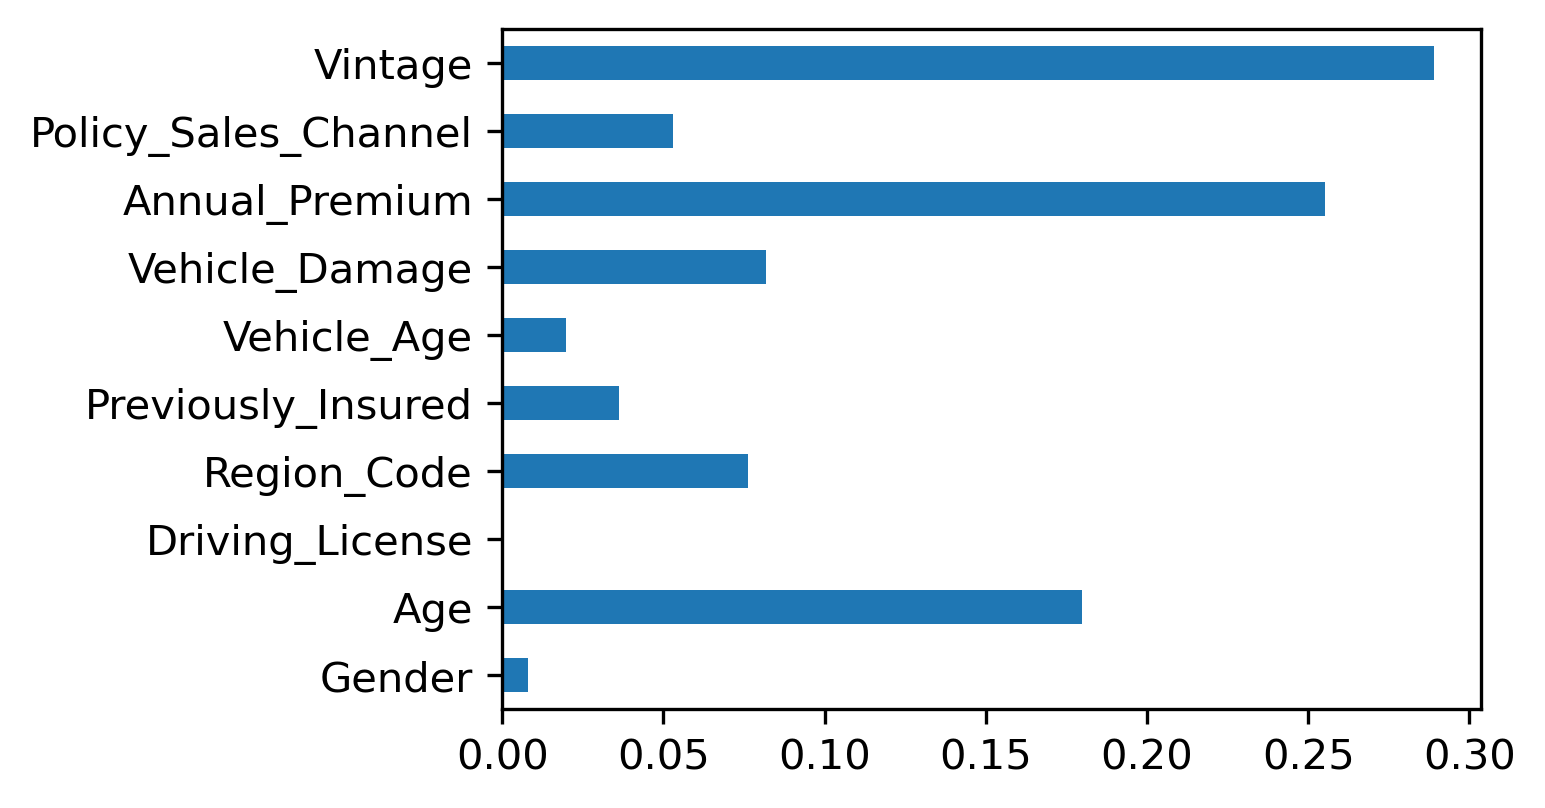

In [284]:
rf_importance_full = pd.Series(rf_model.named_steps['classifier'].feature_importances_, index = rf_feature_names)
rf_importance_agg = pd.Series(full_X.columns.map(lambda cn: rf_importance_full[rf_importance_full.index.str.startswith(cn)].sum()), index = full_X.columns)
rf_importance_agg.plot.barh()#title='Normalized Mean Decrease in Impurity')

In [30]:
rf_pi_results = permutation_importance(rf_model,full_X,full_y)

In [292]:
plt.rcParams['figure.figsize'] = [4.275,3]

<AxesSubplot:>

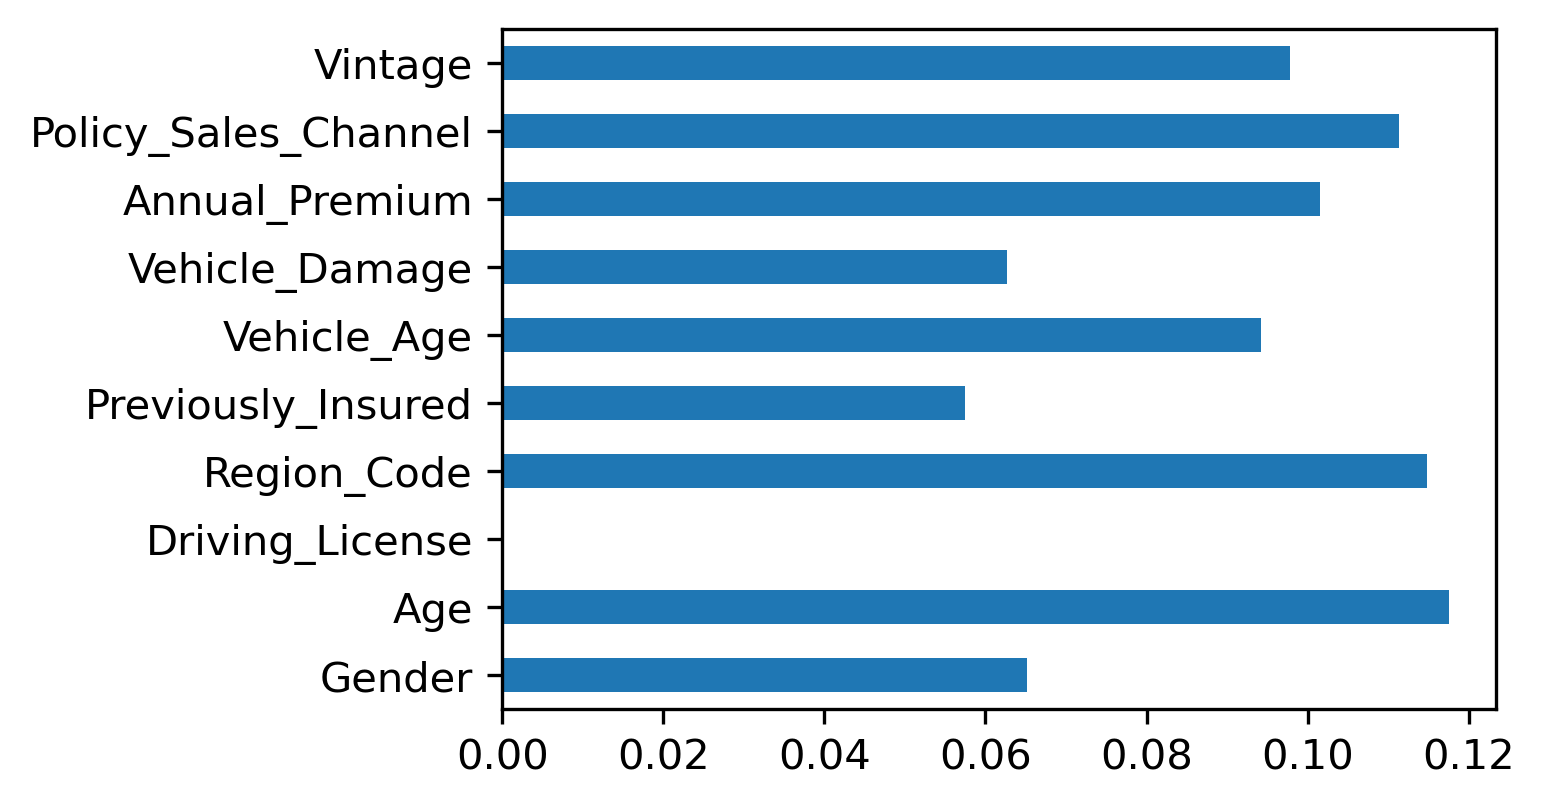

In [293]:
rf_perm_importance_full = pd.Series(rf_pi_results.importances_mean, index = full_X.columns)
rf_perm_importance_full.plot.barh()#title='Permutation Importance (5 repeats)')

In [32]:
from xgboost import XGBClassifier

In [33]:
# # define the model
# xgb_model = XGBClassifier(use_label_encoder = False)
# # fit the model
# xgb_model.fit(full_X_DE.rename(columns={'Vehicle_Age_< 1 Year': 'Vehicle_Age_less than 1 Year', 'Vehicle_Age_> 2 Years':'Vehicle_Age_more than 2 Years'}), full_y)

In [34]:
# xgb_model.get_booster().feature_names

In [35]:
# pd.Series(xgb_model.feature_importances_, index = full_X_DE.columns)

In [36]:
# pd.Series(xgb_model.get_booster().get_score(importance_type='gain'))

In [37]:
# xgb_importance_full = pd.Series(xgb_model.get_booster().get_score(importance_type='weight'))
# xgb_importance_agg = pd.Series(full_X.columns.map(lambda cn: xgb_importance_full[xgb_importance_full.index.str.startswith(cn)].sum()), index = full_X.columns)
# xgb_importance_agg.plot.barh(title='Feature Weight')

In [38]:
xgb_model = Pipeline([
    ('preprocess', preprocessing_xgb),
    ('classifier', XGBClassifier(use_label_encoder = False, random_state = 0))
])

In [39]:
xgb_model.fit(full_X,full_y)

[04:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Gender', 'Region_Code',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', 'passthrough',
                                                  ['Driving_License',
                                                   'Previously_Insured']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               co...
                               importance_

In [40]:
xgb_ohe = xgb_model.named_steps['preprocess'].named_transformers_['cat']

xgb_feature_names_ohe = xgb_ohe.get_feature_names(input_features=categorical_columns)
xgb_feature_names = np.r_[xgb_feature_names_ohe, binary_columns, numerical_columns]

In [81]:
xgb_fn_map = dict(("f" + str(i),xgb_feature_names[i]) for i in range(len(xgb_feature_names)))

In [82]:
xgb_impt_no_names = xgb_model.named_steps['classifier'].get_booster().get_score(importance_type='weight')

In [83]:
xgb_impt_with_names = dict((xgb_fn_map[key],value) for (key,value) in xgb_impt_no_names.items())

In [303]:
plt.rcParams['figure.figsize'] = [4.36,3]

<AxesSubplot:>

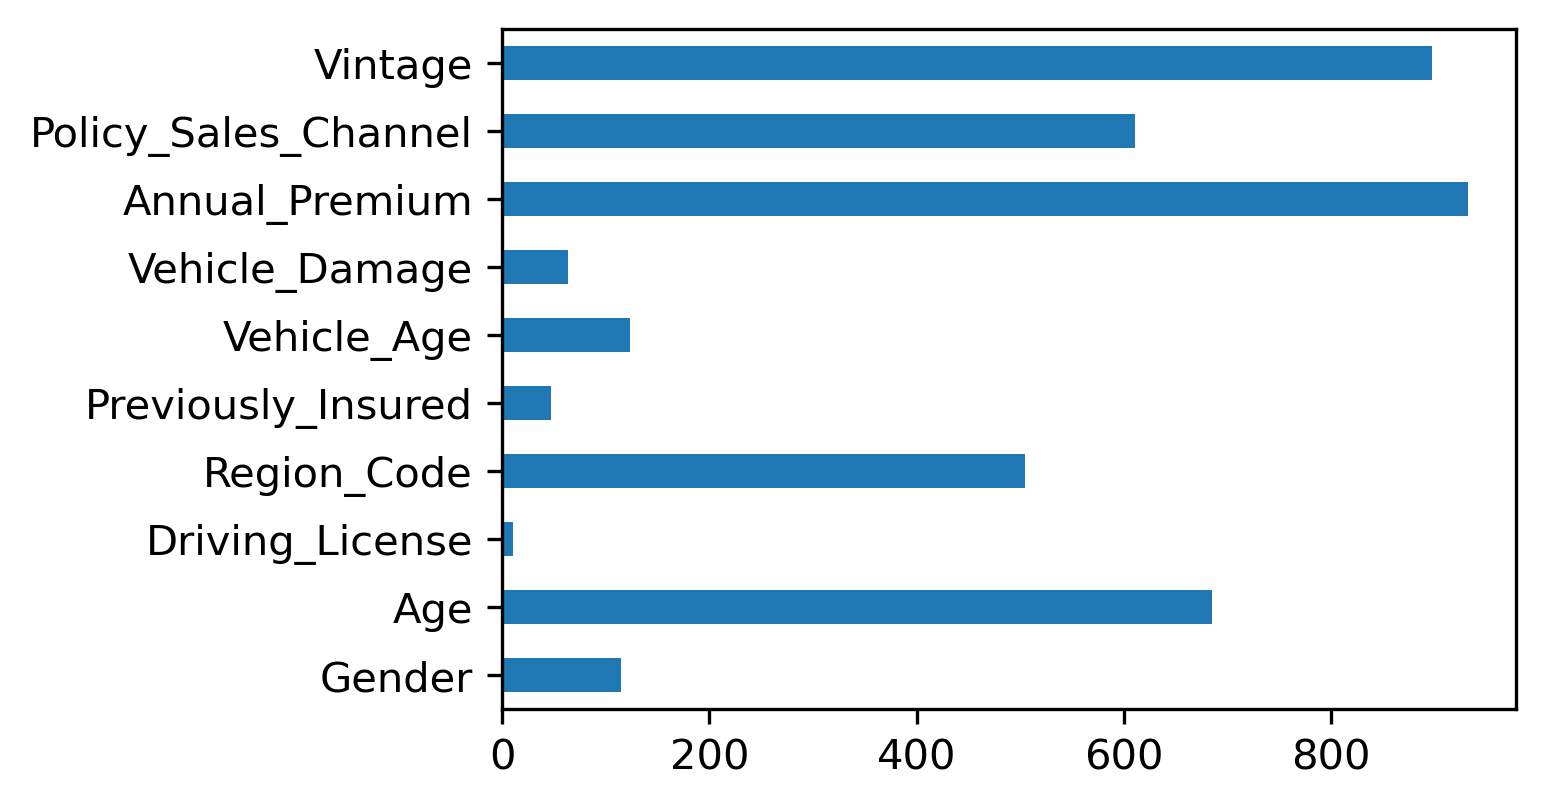

In [304]:
xgb_importance_full = pd.Series(xgb_impt_with_names)
xgb_importance_agg = pd.Series(full_X.columns.map(lambda cn: xgb_importance_full[xgb_importance_full.index.str.startswith(cn)].sum()), index = full_X.columns)
xgb_importance_agg.plot.barh()#title='Feature Weight')

In [42]:
# xgb_importance_full = pd.Series(xgb_model.named_steps['classifier'].feature_importances_, index = xgb_feature_names)
# xgb_importance_agg = pd.Series(full_X.columns.map(lambda cn: xgb_importance_full[xgb_importance_full.index.str.startswith(cn)].sum()), index = full_X.columns)
# xgb_importance_agg.plot.barh(title='Feature Gain')

In [43]:
xgb_pi_results = permutation_importance(xgb_model,full_X,full_y)

In [305]:
plt.rcParams['figure.figsize'] = [4.36,3]

<AxesSubplot:>

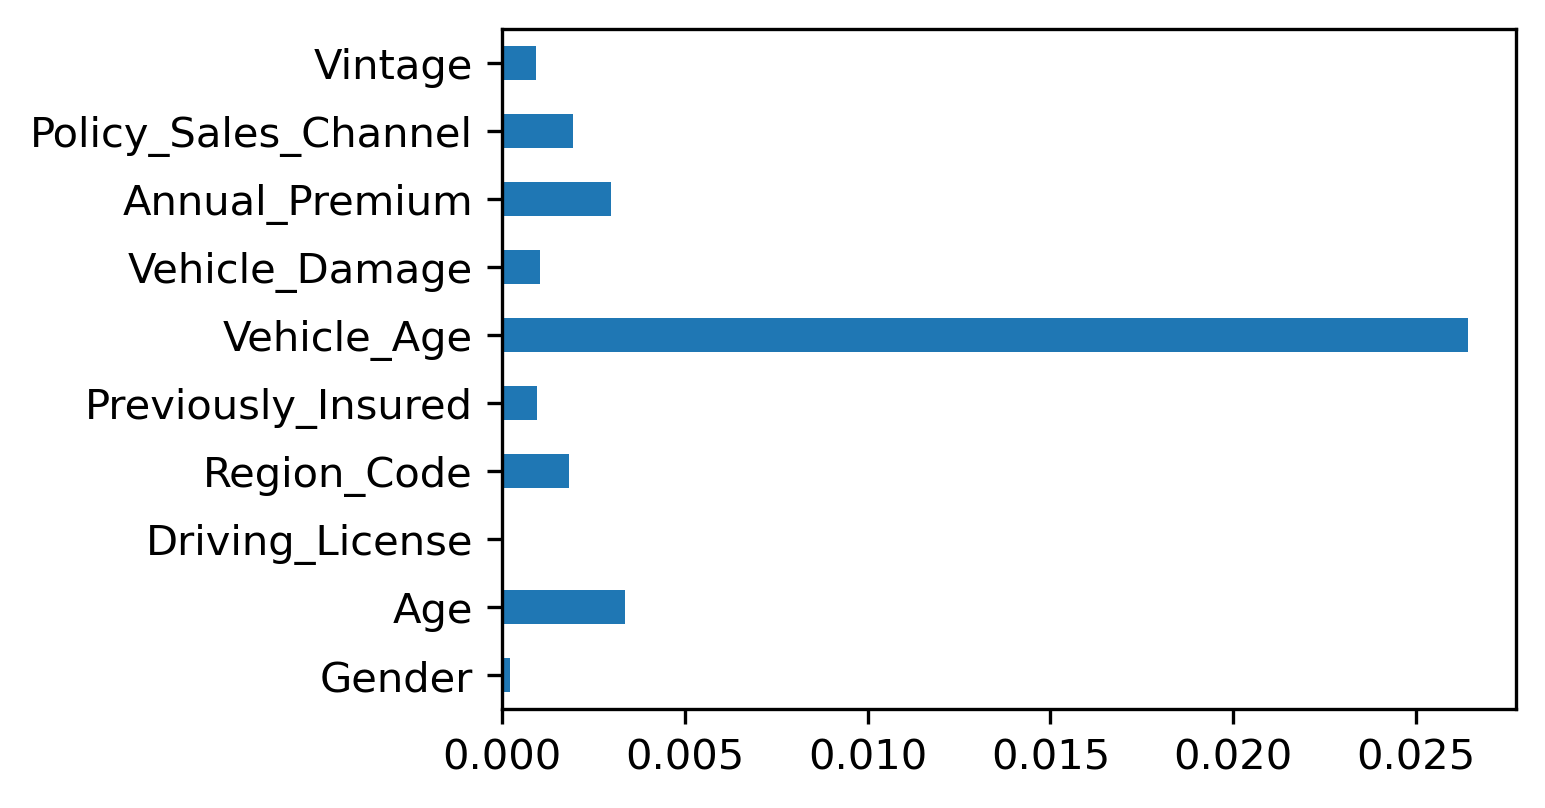

In [307]:
xgb_perm_importance_full = pd.Series(xgb_pi_results.importances_mean, index = full_X.columns)
xgb_perm_importance_full.plot.barh()#title='Permutation Importance (5 repeats)')